In [2]:
%load_ext autoreload
%autoreload 2

try:    importlib.reload(Jupytils)
except: import Jupytils
import logging as log
import itertools as it
showTopbar('''PYAF Test drive''')

from sklearn.linear_model import LinearRegression
from arch.univariate import ARX

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [3]:
df=LoadDataSet("data/test.csv")
dfi=LoadDataSet("data/test.inv.xml", xmlTag="Invariant")
dfi['theta1']= dfi.apply (lambda row: [ float(i.strip()) for i in  row['theta'].split(',') if i.strip()], axis=1)

df

,Time,A,B,C,D,E,F,G
0,60000,94.502,156.473,148.500,64.516,25.060,50.310,47.876
1,120000,94.806,156.706,148.500,64.115,24.957,52.319,47.934
2,180000,94.602,156.691,148.500,64.189,24.691,53.450,48.524
3,240000,94.670,156.496,148.500,62.643,24.726,53.904,49.280
...,...,...,...,...,...,...,...,...
2497,149880000,94.679,157.041,148.500,61.631,25.016,50.494,48.733
2498,149940000,94.594,156.820,148.500,61.752,25.122,51.641,48.855
2499,150000000,95.229,156.739,148.500,62.567,25.575,52.215,49.056
2500,150060000,94.884,156.338,148.500,63.870,25.444,53.483,49.159


In [4]:
#display(HTML(dfi.to_html()))
dfi.sort_values(['uName', 'yName'], inplace=True)
displayDFs(dfi, showIcons=False);

,uName,yName,fitness,correlation,validity,theta,n,m,k,threshold,slope,intercept,theta1
4,A,B,0.8356905058951782,1.0,1.0,"0.7566798046980097,0.08742089615341801,76.55782422422585",0,1,0,4.617520279747,0.0,0.0,"[0.7566798046980097, 0.08742089615341801, 76.55782422422585]"
0,A,D,0.29655860010845936,1.0,1.0,"-0.9630133424708321,0.023043866594117834,0.10041268310120169",1,0,2,3.406622459967531,0.0,0.0,"[-0.9630133424708321, 0.023043866594117834, 0.10041268310120169]"
8,A,E,0.16186693354785164,1.0,1.0,"0.34367147588451813,-0.34042215819690835,24.711512869990965",0,1,0,2.2843646765284835,0.0,0.0,"[0.34367147588451813, -0.34042215819690835, 24.711512869990965]"
6,A,F,0.7211136678564295,1.0,1.0,"-0.7120381334303367,0.20514306199581256,0.18059555568220276,-21.856425676200672",1,1,2,5.69048879407507,0.0,0.0,"[-0.7120381334303367, 0.20514306199581256, 0.18059555568220276, -21.856425676200672]"
1,A,G,0.1252050411122706,1.0,1.0,"-0.5345073561536757,-0.0029261322711296245,-0.044098931439243885,27.32336917086615",1,1,0,3.28462926090997,0.0,0.0,"[-0.5345073561536757, -0.0029261322711296245, -0.044098931439243885, 27.32336917086615]"
5,B,A,0.8428445919493313,1.0,1.0,"0.5722391154919677,0.5838044266562292,-86.3624790442679",0,1,0,4.154889470245979,0.0,0.0,"[0.5722391154919677, 0.5838044266562292, -86.3624790442679]"


In [ ]:
def ARXModel(y, x, n,m,k):
    if (x is None):
        xx = None
    else:
        xxx=[]
        for i in range(m, -1, -1):
            to = -(m+k-i) if ((m+k-i) > 0) else None
            xxx.append(x[i:to]);
            #print(i, -(m+k-i))

        xx = np.hstack(xxx)
        
    #print ( "===>", len(xx))
    arx = ARX(y[m+k:],xx, lags=n)
    res = arx.fit()
    return res, arx;

x=df['A'].values    
y=df['B'].values

ARXModel(y, x, 0, 1, 0);

In [124]:
def Theta(res,n):
    theta=list(res.params[1:n+1].values * -1) +  list(res.params[n+1:-1]) + [res.params[0]]
    return np.array(theta)

def formatRes(res,n):
    theta1=''
    for i,j in res.params[1:n+1].items(): 
        theta1 += "{:7.4f}, ".format(-j)
    for i,j in res.params[n+1:-1].items(): 
        theta1 += "{:7.4f}, ".format(j)

    theta1 += "{:7.4f}, ".format(res.params[0])
    
    return theta1

def formatRes(res,n):
    theta1=''
    for i,j in res.params[1:n+1].items(): 
        theta1 += "{}, ".format(-j)
    for i,j in res.params[n+1:-1].items(): 
        theta1 += "{}, ".format(j)

    theta1 += "{}, ".format(res.params[0])
    
    return theta1

def FitnessAR(y):
    bestFit, bestN, bestRes = (None,None,None)
    for n in range(1,4):
        arx = ARX(y,None, lags=n)
        res = arx.fit()

        th = Theta(res,n);
        ffitc,_,_,thr = FitnessScore(None,y,n,-1,0, th)
        if (bestFit is None or ffitc > bestFit):
            bestFit = ffitc; bestN=n; bestRes = res;

        print ("n", n, ffitc, th, max(abs(res.resid[1:]))*1.05)

    print ("best Fit: {} n: {}".format(bestFit, bestN ) )
    thresh = max(abs(bestRes.resid[bestN:]) ) *1.05
    
    return bestFit, bestN, bestRes, thresh

def ARXModel(y, x, n,m,k):
    if (x is None):
        xx = None
    else:
        xxx=[]
        for i in range(m, -1, -1):
            to = -(m+k-i) if ((m+k-i) > 0) else None
            xxx.append(x[i:to]);
            #print(i, -(m+k-i))

        xx = np.hstack(xxx)
        
    #print ( "===>", len(xx))
    arx = ARX(y[m+k:],xx, lags=n)
    res = arx.fit()
    return res, arx;

def INVXByName(df, yName, uName,n,m,k):
    y= df[yName]
    x= None if uName is None else np.matrix(df[uName]).transpose() 
    ret = ARXModel(y,x,n,m,k)
    return ret;

def INVX(y, x,n,m,k):
    x= None if x is None else np.matrix(x).transpose() 
    ret = ARXModel(y,x,n,m,k)
    return ret;

def INVG(dfi, r=0):
    dd = dfi.ix[r]
    uName,yName,n,m,k,th,f,trh=dd['uName'], dd['yName'], int(dd['n']), int(dd['m']), int(dd['k']), dd['theta'], float(dd['fitness']),float(dd['threshold'])
    t=''
    for i in  th.split(','):
        if ( not i.strip()): continue;
        t += "{:7.4f}, ".format(float(i.strip()))
    return uName,yName,n,m,k,t,f,trh


def INVRow(dfi, r=0):
    dd = dfi.ix[r]
    ret = dd
    ret.t = [ float(i.strip()) for i in  dd['theta'].split(',') if i.strip()]
    for i in range(ret.n): 
        ret.t[i] = ret.t[i]; 
    return ret


#Theta is a parameter matrix [n-coeffs, m-coffients, constant]
def predict(x, y, n,m,k, theta, t, updateArray=True):
    s = max(n, (m+k))
    if( t < s):
        print("Hmmm Passing an index i:{} resetting to {}".format(i,s))
        t=s
    
    if (x is None):
        p= list(reversed(y[t-n:t] * -1)) + [0] * (1+m)  + [1]
    else:
        p= list(reversed(y[t-n:t] * -1)) + list(reversed(x[t-m-k:t-k+1])) + [1]
    
    yh = (np.array(p).dot(theta))
    rs = (y[t] - yh)
    return yh,rs

# Just faster version of Predict (I think - may be not)
def predict1(x, y, n,m,k, theta, t, log=False):
    yh=0 
    for i in range(n):
        yh += y[t-i-1] * theta[i] * -1.0
        if ( log): print("yh = {} * {} * {}".format(y[t-i-1] , theta[i] , -1.0), end='')
    for i in range(m+1):
        yh += x[t-m-k+i] * theta[n+m-i]
        if ( log): print(" + {} * {} ".format(x[t-m-k+i] , theta[n+m-i]), end='')

    if ( log):  print(" + {} ".format(theta[-1]))

    yh += theta[-1]
    return yh, y[t] - yh

def FitnessScore(x, y, n,m,k,theta, needArrays=True, useSlowPredict=True):
    s=max(n,m+k)
    denom = sum((y[s:]-mean(y[s:]))**2)
    yhat=np.array(y.copy())
    residueFit=[]
    sumResidue = 0;
    for t in range(s,len(y)):  # <= predict all possible candidates
        if (useSlowPredict):
            yyFit,rrFit = predict(x, yhat, n,m,k, theta, t)
        else:
            yyFit,rrFit = predict1(x, yhat, n,m,k, theta, t)
            
        yhat[t] = yyFit
        sumResidue += rrFit ** 2
        
        if (needArrays):
            residueFit.append(rrFit)
   
    fitness = 1-sqrt(sumResidue/denom)
    return fitness,yhat,residueFit;

def findBest(y, x, useSlowPredict=True):
    best=Map({});
    for n in range(3):
        for m in range(2):
            for k in range(3):
                res, arx = INVX(y, x,n,m,k)
                theta= Theta(res,n)
                fitscore,yh,rs = FitnessScore(x,y,n,m,k, theta, False,useSlowPredict)
                    
                if (best.res is None or fitscore > best.fitscore ): 
                    best.res = res; best.rs=rs; best.nmk= (n,m,k); best.fitscore = fitscore; 
                    best.n=n; best.m=m; best.k=k;
                    
    best.threshold= max(abs(best.res.resid[best.nmk[0]:]) ) * 1.05
    best.cor = np.corrcoef(x,y)[0,0]
        
    return best;

log.getLogger().setLevel(log.WARN)
def CreateInvariants(df, filename="inv.xml", columns=[]):
    if ( len(df) <= 2 or len(df.columns) <= 1):
        raise Exception("Not enough data in the dataframe")
        
    cols = 'uName,yName,fitness,correlation,validity,theta,n,m,k,threshold,slope,intercept'.split(',')
    dfi = pd.DataFrame(columns=cols);
    newcols=[df.columns[0]]
    
    for c in df.columns[1:]:
        if len(df[c].unique()) > 1:
            newcols.append(c)
    if (len(newcols) < len(df.columns)):
        df = df[newcols]
        
    log.info("Creating invariants using {}".format( df.columns[1:]) )
    for u in df.columns[1:]:
        for v in df.columns[1:]:
            if (u == v):
                continue;
            if ( columns is not None and len(columns) > 0 and (u not in columns) ):
                print("Skipping ....", u, len(columns))
                continue;
                
            x=df[u].values    
            y=df[v].values
            ret = findBest(y, x, False);
            inv1 = [u,v,ret.fitscore, ret.cor, 1, formatRes(ret.res,ret.n), ret.nmk[0], ret.nmk[1], ret.nmk[2], ret.threshold, 0.0, 0.0]
            ret = findBest(x, y, False);
            log.info("{}".format(inv1) )
            dfi.loc[len(dfi)] = inv1
                
    if ( filename is not None):
        dfi.to_csv(filename, index=False)
    
    dfi.sort_values(['uName', 'yName'], inplace=True)
    dfi['theta1']= dfi.apply (lambda row: [ float(i.strip()) for i in  row['theta'].split(',') if i.strip()], axis=1)

    return dfi

#########################################################################################################
def test(r=0):
    uName,yName,n,m,k,fth,fits,trs = INVG(dfi,r =r);
    print(r, "===========>")
    print("=>INV.XML:  {} fit:{:7.6f} thresHold: {:7.5f} nmk: {} ==> u: {} y: {} ".format(fth,  fits, trs, (n,m,k),uName, yName ) )

    y=df[yName].values
    x=df[uName].values
    res,arx = INVX(y, x, n,m,k, yName, uName)
    fitc,th, rs= FitnessScore(x,y,n,m,k,Theta(res,n))
    mthr = max(abs(res.resid[n:]) ) *1.05
    
    #==> Verify
    print("=>COMPUTED: {} fit:{:7.6f} threshold: {:7.5f}".format(formatRes(res,n), fitc, mthr))

    #==> Compute Best FIT for a pair
    ret = findBest(df, y, x, True);
    cor = np.corrcoef(x,y)[0,0]
    print("=>BEST FIT: {} fit:{:7.6f} threshold: {:7.5f} nmk: {}".format(formatRes(ret.res,n), ret.fitscore, ret.threshold, ret.nmk) )

def test1(r=0):
    uName,yName,n,m,k,fth,fits,trs = INVG(dfi,r =r);
    y=df[yName].values
    x=df[uName].values    
    ret = findBest(df, y, x, False);
    if((n,m,k) != ret.nmk or abs(ret.fitscore-fits) > 0.06 or (ret.threshold-trs)>0.05):
        print("{:4d} Expected {} got {}".format(r,(n,m,k), ret.nmk))
        print("=>INV.XML:  {} fit:{:7.6f} thresHold: {:7.5f} nmk: {} ==> u: {} y: {} ".format(fth,  fits, trs, (n,m,k),uName, yName ) )
        print("=>BEST FIT: {} fit:{:7.6f} threshold: {:7.5f} nmk: {}".format(formatRes(ret.res,n), ret.fitscore, ret.threshold, ret.nmk) )

def testall():
    for i in range(0,len(dfi)):
        test1(i)

test(4)

#%time test1(len(dfi)-12);

%time invs=CreateInvariants(df)
anomDF=LoadDataSet("data/test-ab20.csv")


4 ===========>
=>INV.XML:   0.7567,  0.0874, 76.5578,  fit:0.835691 thresHold: 4.61752 nmk: (0, 1, 0) ==> u: A y: B 
=>COMPUTED: 0.7566798046979761, 0.08742089615344417, 76.55782422422575,  fit:0.835691 threshold: 4.61752
=>BEST FIT: 0.7566798046979761, 0.08742089615344417, 76.55782422422575,  fit:0.835691 threshold: 4.61752 nmk: (0, 1, 0)
CPU times: user 10.4 s, sys: 76 ms, total: 10.4 s
Wall time: 10.4 s


In [126]:
def DetectAnomaly(t, invDF, anomDF, sumFitness, edgeCounts, logdetailed=True ):
    ret = Map({})
    ret.t = t;
    ret.anomScore = 0;
    ret.brokenInvs= 0;
    ret.SumSignif = 0;
    ret.brkSignif = 0;
    ret.scores = []
    ret.sumFitness = sumFitness; #sum(invDF.fitness.astype(float));

    ret.brkns = Map({});
    for i in range(len(invDF)):
        r = INVRow(invDF,r = i)
        
        brkn= Map({})
        brkn.brknFitSum =0;
        brkn.r = r
        u=anomDF[r.uName].values
        y=anomDF[r.yName].values
        brkn.uName, brkn.yName, brkn.nmk = r.uName, r.yName, (r.n, r.m, r.k)
        ret.brkns[brkn.uName+":"+brkn.yName] = brkn
        
        thetaArray = invDF.ix[i].theta1;
        #if(r.t != thetaArray): print(r.t , thetaArray )
        
        brkn.yh, brkn.res = predict1(u, y, r.n, r.m, r.k, thetaArray, t, False)
        brkn.sigf  = abs(brkn.res)/r.threshold
        ret.SumSignif += brkn.sigf
        brkn.wsigf     = brkn.sigf * r.fitness
        brkn.broken = " "
        brkn.y = y[t]
        
        if (abs(brkn.res) > r.threshold * 1.1):
            brkn.broken = "*"
            ret.anomScore += r.fitness
            ret.brokenInvs+= 1
            ret.brkSignif += brkn.sigf

    #    break;
    
        #if (logdetailed): 
        #    print("{} {:2d} {} {} fit: {:.4f} Sigf: {:10.4f}({:7.4f}) score: {:6.2f} - {:6.2f} = {:8.2f}, thresh: {:12.6f}".format(brkn.broken,\
        #        i, (brkn.uName, brkn.yName), brkn.nmk, brkn.r.fitness, brkn.sigf, brkn.wsigf, brkn.y, brkn.yh, brkn.res, brkn.r.threshold* 1.1) )

    ret.suspicions, ret.suspicionsCounts = suspicions(ret, edgeCounts, logdetailed);
    print( "Score: {:3d} Anom:{:10.4f} normedAnom: {:6.4f} brk:{:3d}".format(t, ret.anomScore, ret.anomScore/ret.sumFitness , ret.brokenInvs) )
    return ret;
      
def suspicions(ret, edgeCounts, logDetailed=True):
    bvars=defaultdict(int)
    bvarsCount=defaultdict(int)
    bfits=0;
    for i,brkn in sorted(ret.brkns.items()):
        #print(i)
        if (logDetailed):
            print("{} {} {} fit: {:.4f} Sigf: {:10.4f}({:7.4f}) score: {:6.2f} - {:6.2f} = {:8.2f}, thresh: {:12.6f}".format(brkn.broken,\
            i, brkn.nmk, brkn.r.fitness, brkn.sigf, brkn.wsigf, brkn.y, brkn.yh, brkn.res, brkn.r.threshold* 1.1) )
        if ( brkn.broken.strip()):
            bvars[brkn.uName] += brkn.r.fitness
            bvars[brkn.yName] += brkn.r.fitness
            bvarsCount[brkn.uName] += 1
            bvarsCount[brkn.yName] += 1
            #bvars[brkn.uName] += 1
            
    for i, k in sorted(bvars.items()):
        bvars[i] = k/edgeCounts[i]
        if (logDetailed): print(i, bvars[i]), edgeCounts
    return bvars, bvarsCount;
        

def FindResiduals(df, invDF, anomDF, start=None,stop=None, detailedLog=False):
    maxLag = max(max(invDF.n),max(invDF.m+invDF.k))
    start  = maxLag if start is None or start < maxLag else start
    stop   = len(anomDF) if stop is None or stop >= len(anomDF) else stop
    
    allUVs   = list(invDF.uName.values) + list(invDF.yName.values)
    nodes  = unique(allUVs)
    edgeCounts=pd.value_counts(pd.Series(allUVs))
    edges  = unique(list(invDF.uName.values + ":"+ invDF.yName.values))
    sumFit = sum(invDF.fitness.astype(float))
    print("maxLag: {}, Number Nodes: {}, Number of Invariants: {}, sumFit: {}, ".format(maxLag, len(nodes), len(edges), sumFit))

    ret=Map({})
    for t in range(start, stop):
        ret[t]=DetectAnomaly(t, invDF, anomDF, sumFit, edgeCounts, detailedLog)

    return ret, edgeCounts;

#ret, edgeCounts = FindResiduals(df, invs, anomDF, 3,94, False);
ret, edgeCounts = FindResiduals(df, dfi, anomDF, 3,94, False);
#dfi.ix[0].theta1


maxLag: 3, Number Nodes: 6, Number of Invariants: 30, sumFit: 8.820847628339415, 
Score:   3 Anom:    7.0306 normedAnom: 0.7970 brk: 22
Score:   4 Anom:    7.0306 normedAnom: 0.7970 brk: 22
Score:   5 Anom:    7.2129 normedAnom: 0.8177 brk: 22
Score:   6 Anom:    7.2129 normedAnom: 0.8177 brk: 22
Score:   7 Anom:    7.2129 normedAnom: 0.8177 brk: 22
Score:   8 Anom:    7.2129 normedAnom: 0.8177 brk: 22
Score:   9 Anom:    7.2129 normedAnom: 0.8177 brk: 22
Score:  10 Anom:    6.9116 normedAnom: 0.7836 brk: 21
Score:  11 Anom:    7.2129 normedAnom: 0.8177 brk: 22
Score:  12 Anom:    6.9116 normedAnom: 0.7836 brk: 21
Score:  13 Anom:    6.9116 normedAnom: 0.7836 brk: 21
Score:  14 Anom:    7.2129 normedAnom: 0.8177 brk: 22
Score:  15 Anom:    7.2129 normedAnom: 0.8177 brk: 22
Score:  16 Anom:    7.2129 normedAnom: 0.8177 brk: 22
Score:  17 Anom:    7.2129 normedAnom: 0.8177 brk: 22
Score:  18 Anom:    6.9116 normedAnom: 0.7836 brk: 21


Broken Invariants:
A:B * 7.0046332378757095
A:D   0.5431483637633965
A:E * 3.973274009338831
A:F * 5.037699826079129
A:G * 3.183889589640062
B:A * 8.743524271865592
B:D   0.8020967523580584
B:E * 5.041233238401832
B:F * 8.105541683565868
B:G * 4.337748624813015
D:A * 4.183757978934547
D:B * 7.724996805111115
D:E * 10.281475782937857
D:F   0.026887471114339034
D:G * 3.891778428169111
E:A * 1.2088201251615722
E:B   0.040864242753101944
E:D * 23.204412957056576
E:F   0.45980996569011645
E:G * 1.210651175077376
F:A * 5.496055946782103
F:B * 8.883533096755492
F:D   0.03235165961617962
F:E * 5.046616268115671
F:G * 5.104426807393681
G:A * 7.449172301846627
G:B * 9.817688330726458
G:D   0.3158522855409344
G:E * 6.549964959563367
G:F   0.9474781725850256

Suspicious Metrics:
A 0.3852209820018751 9 10
B 0.353105550188963 8 10
D 0.1523265955962317 5 10
E 0.12771057649477888 8 10
F 0.30896273880916775 6 10
G 0.09041219032780828 8 10


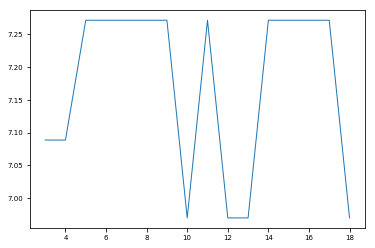

In [78]:
line=4

#Show Plot for all the anomalies entries
an=[]
for k in sorted(ret.keys()):
    an.append(ret[k].anomScore)
    #print(k, ret[k].anomScore)
plt.plot(sorted(ret.keys()), an);

print("Broken Invariants:")
for k in sorted(ret[line].brkns.keys()):
    print(k, ret[line].brkns[k].broken, ret[3].brkns[k].sigf)

print("\nSuspicious Metrics:")
for k,v in sorted(ret[line].suspicions.items()):
    scount = ret[line].suspicionsCounts[k]
    ecount = edgeCounts[k]
    print(k,v, scount, ecount)


In [134]:
def timeStamp(strptime="5/4/2016 11:19"):
    dt=pd.to_datetime(strptime, utc=True)
    return int(dt.timestamp()*1000)

def closestRow(pseries, time='6/19/2016'):
    dt1=timeStamp(time)
    r = np.argmin(np.abs(pseries - dt1))
    return r

def isInt(s):
    ret = None;
    try:
        ret = int(s)
    except ValueError:
        pass;
    
    return ret

#test 
tt = ("5/6/2017 10:20")
closestRow(df.ix[:,0], tt)
timeStamp('6/19/2016')

time1 = datetime.datetime.now()
time2 = datetime.datetime.now()

10000/60/60

2.7777777777777777

In [304]:
invFile = "/NEC/workingDir/p31/cr12_7.inv.xml"

invDF=LoadDataSet(invFile, xmlTag="Invariant")
invDF = invDF.infer_objects()
invDF = invDF['uName yName fitness theta n m k threshold'.split()]
invDF.fitness  = invDF.fitness.astype(float)
invDF.threshold= invDF.threshold.astype(float)
invDF.n = invDF.n.astype(int)
invDF.m = invDF.m.astype(int)
invDF.k = invDF.k.astype(int)
invDF['theta1']= invDF.apply (lambda row: thetaF(row),axis=1)  # Convert to float array
invDFA = invDF.as_matrix()
invDFC = Map({})
for i, c in enumerate(invDF.columns):
    invDFC[c] = i;
        

In [390]:
allUVs   = list(invDF.uName.values) + list(invDF.yName.values)
nodes  = np.unique(allUVs)
nodes

array(['CR2_0002', 'CR2_0006', 'CR2_0011', 'CR2_0015', 'CR2_0016', 'CR2_0017', 'CR2_0018', 'CR2_0019', 'CR2_0020', 'CR2_0025', 'CR2_0026', 'CR2_0045', 'CR2_2719', 'CR2_3518', 'CR2_4228', 'CR2_4229', 'CR2_4231', 'CR2_4276', 'CR2_4277', 'CR2_4278', 'CR2_4279', 'CR2_4280', 'CR2_4281', 'CR2_4282', 'CR2_4283', 'CR2_4287', 'CR2_4288', 'CR2_4289', 'CR2_4290', 'CR2_4292', 'CR2_4293', 'CR2_4294', 'CR2_4295', 'CR2_4296', 'CR2_4297', 'CR2_4298', 'CR2_4299', 'CR2_4300', 'CR2_4301', 'CR2_4302', 'CR2_4303', 'CR2_4304', 'CR2_4305', 'CR2_4306', 'CR2_4307', 'CR2_4308', 'CR2_4312', 'CR2_4313', 'CR2_4315', 'CR2_4316', 'CR2_4317', 'CR2_4318', 'CR2_4319', 'CR2_4320', 'CR2_4321', 'CR2_4322', 'CR2_4324', 'CR2_4325', 'CR2_4326', 'CR2_4327', 'CR2_4328', 'CR2_4329', 'CR2_4330', 'CR2_4331', 'CR2_4332', 'CR2_4333', 'CR2_4334', 'CR2_4335', 'CR2_4336', 'CR2_4337', 'CR2_4338', 'CR2_4339', 'CR2_4340', 'CR2_4341', 'CR2_4342', 'CR2_4343', 'CR2_4344', 'CR2_4345', 'CR2_4346', 'CR2_4347', 'CR2_4348', 'CR2_4349',
       'C

In [395]:
tdf = LoadDataSet("/NEC/workingDir/p31/testa_RankScores.csv")
tdf

,CR2_0002,CR2_0006,CR2_0011,CR2_0015,CR2_0016,CR2_0017,CR2_0018,CR2_0019,CR2_0020,CR2_0025,CR2_0026,CR2_0045,CR2_2719,CR2_3518,CR2_4228,CR2_4229,CR2_4231,CR2_4276,CR2_4277,CR2_4278,CR2_4279,CR2_4280,CR2_4281,CR2_4282,CR2_4283,CR2_4287,CR2_4288,CR2_4289,CR2_4290,CR2_4292,CR2_4293,CR2_4294,CR2_4295,CR2_4296,CR2_4297,CR2_4298,CR2_4299,CR2_4300,CR2_4301,CR2_4302,CR2_4303,CR2_4304,CR2_4305,CR2_4306,CR2_4307,CR2_4308,CR2_4312,CR2_4313,CR2_4315,CR2_4316,CR2_4317,CR2_4318,CR2_4319,CR2_4320,CR2_4321,CR2_4322,CR2_4324,CR2_4325,CR2_4326,CR2_4327,CR2_4328,CR2_4329,CR2_4330,CR2_4331,CR2_4332,CR2_4333,CR2_4334,CR2_4335,CR2_4336,CR2_4337,CR2_4338,CR2_4339,CR2_4340,CR2_4341,CR2_4342,CR2_4343,CR2_4344,CR2_4345,CR2_4346,CR2_4347,CR2_4348,CR2_4349,CR2_4350,CR2_4351,CR2_4352,CR2_4353,CR2_4354,CR2_4355,CR2_4356,CR2_4357,CR2_4358,CR2_4359,CR2_4360,CR2_4361,CR2_4362,CR2_4363,CR2_4364,CR2_4365,CR2_4366,CR2_4367,CR2_4368,CR2_4369,CR2_4370,CR2_4371,CR2_4372,CR2_4373,CR2_4374,CR2_4375,CR2_4376,CR2_4377
1464733440000.000,0.003,0.008,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.008,0.001,0.000,0.000,0.001,0.003,0.000,0.001,0.008,0.003,0.003,0.000,0.002,0.001,0.001,0.009,0.004,0.000,0.003,0.017,0.007,0.001,0.000,0.007,0.007,0.006,0.017,0.010,0.024,0.038,0.007,0.003,0.000,0.000,0.000,0.000,0.022,0.015,0.009,0.005,0.002,0.002,0.001,0.011,0.007,0.001,0.004,0.000,0.003,0.001,0.001,0.002,0.001,0.001,0.002,0.012,0.001,0.002,0.002,0.006,0.007,0.002,0.004,0.004,0.003,0.016,0.001,0.001,0.002,0.005,0.003,0.001,0.003,0.006,0.003,0.001,0.001,0.010,0.004,0.001,0.001,0.002,0.001,0.003,0.014,0.010,0.002,0.002,0.005,0.000,0.002,0.001,0.001,0.001,0.011,0.004,0.000,0.000,0.000,0.000
1464733500000.000,0.007,0.008,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.008,0.001,0.000,0.000,0.001,0.007,0.000,0.001,0.008,0.003,0.003,0.000,0.002,0.001,0.001,0.009,0.004,0.000,0.003,0.017,0.007,0.001,0.000,0.007,0.007,0.006,0.017,0.010,0.024,0.038,0.007,0.003,0.000,0.000,0.000,0.000,0.022,0.015,0.009,0.005,0.002,0.002,0.001,0.011,0.007,0.001,0.004,0.000,0.003,0.001,0.001,0.002,0.001,0.001,0.002,0.010,0.001,0.003,0.002,0.006,0.012,0.002,0.004,0.002,0.003,0.015,0.001,0.001,0.002,0.005,0.003,0.001,0.003,0.008,0.003,0.001,0.001,0.013,0.004,0.001,0.001,0.002,0.001,0.003,0.014,0.010,0.005,0.002,0.005,0.000,0.002,0.001,0.001,0.001,0.011,0.004,0.000,0.000,0.000,0.000
1464733560000.000,0.002,0.008,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.008,0.001,0.000,0.000,0.001,0.002,0.000,0.001,0.008,0.003,0.003,0.000,0.002,0.001,0.001,0.009,0.004,0.000,0.003,0.017,0.007,0.001,0.000,0.007,0.007,0.006,0.017,0.010,0.024,0.038,0.007,0.003,0.000,0.000,0.000,0.000,0.022,0.015,0.009,0.005,0.002,0.002,0.001,0.011,0.007,0.001,0.004,0.000,0.003,0.001,0.001,0.002,0.001,0.001,0.002,0.010,0.001,0.002,0.002,0.006,0.007,0.002,0.004,0.002,0.003,0.016,0.001,0.001,0.002,0.005,0.003,0.001,0.003,0.006,0.003,0.001,0.001,0.010,0.004,0.001,0.001,0.002,0.001,0.003,0.016,0.010,0.002,0.002,0.005,0.000,0.002,0.001,0.001,0.001,0.011,0.004,0.000,0.000,0.000,0.000
1464733620000.000,0.004,0.008,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.008,0.001,0.000,0.000,0.001,0.004,0.000,0.001,0.008,0.003,0.003,0.000,0.002,0.001,0.001,0.009,0.004,0.000,0.003,0.017,0.007,0.001,0.000,0.007,0.007,0.006,0.017,0.010,0.024,0.038,0.007,0.003,0.000,0.000,0.000,0.000,0.022,0.015,0.009,0.005,0.002,0.002,0.001,0.011,0.007,0.001,0.004,0.000,0.003,0.001,0.001,0.002,0.001,0.001,0.002,0.012,0.001,0.002,0.002,0.006,0.007,0.002,0.004,0.004,0.003,0.016,0.001,0.001,0.002,0.005,0.003,0.001,0.003,0.006,0.003,0.001,0.001,0.010,0.004,0.001,0.001,0.002,0.001,0.003,0.016,0.010,0.002,0.002,0.006,0.000,0.002,0.001,0.001,0.001,0.011,0.004,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [397]:
udf=LoadDataSet("/NEC/workingDir/p31/cr12_7_anom_score.csv")
udf= udf[sorted(udf.columns)]
udf

,CR2_0002,CR2_0006,CR2_0011,CR2_0015,CR2_0016,CR2_0017,CR2_0018,CR2_0019,CR2_0020,CR2_0025,CR2_0026,CR2_0045,CR2_2719,CR2_3518,CR2_4228,CR2_4229,CR2_4231,CR2_4276,CR2_4277,CR2_4278,CR2_4279,CR2_4280,CR2_4281,CR2_4282,CR2_4283,CR2_4287,CR2_4288,CR2_4289,CR2_4290,CR2_4292,CR2_4293,CR2_4294,CR2_4295,CR2_4296,CR2_4297,CR2_4298,CR2_4299,CR2_4300,CR2_4301,CR2_4302,CR2_4303,CR2_4304,CR2_4305,CR2_4306,CR2_4307,CR2_4308,CR2_4312,CR2_4313,CR2_4315,CR2_4316,CR2_4317,CR2_4318,CR2_4319,CR2_4320,CR2_4321,CR2_4322,CR2_4324,CR2_4325,CR2_4326,CR2_4327,CR2_4328,CR2_4329,CR2_4330,CR2_4331,CR2_4332,CR2_4333,CR2_4334,CR2_4335,CR2_4336,CR2_4337,CR2_4338,CR2_4339,CR2_4340,CR2_4341,CR2_4342,CR2_4343,CR2_4344,CR2_4345,CR2_4346,CR2_4347,CR2_4348,CR2_4349,CR2_4350,CR2_4351,CR2_4352,CR2_4353,CR2_4354,CR2_4355,CR2_4356,CR2_4357,CR2_4358,CR2_4359,CR2_4360,CR2_4361,CR2_4362,CR2_4363,CR2_4364,CR2_4365,CR2_4366,CR2_4367,CR2_4368,CR2_4369,CR2_4370,CR2_4371,CR2_4372,CR2_4373,CR2_4374,CR2_4375,CR2_4376,CR2_4377,Time
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1462060980000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1462061040000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1462061100000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1462061160000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,